# Entity Service Similarity Scores Output

This tutorial demonstrates generating CLKs from PII, creating a new project on the entity service, and how to retrieve the results. 
The output type is raw similarity scores. This output type is particularly useful for determining a good threshold for the greedy solver used in mapping.

The sections are usually run by different participants - but for illustration all is carried out in this one file. The participants providing data are *Alice* and *Bob*, and the analyst is acting as the integration authority.

### Who learns what?

Alice and Bob will both generate and upload their CLKs.

The analyst - who creates the linkage project - learns the `similarity scores`. Be aware that this is a lot of information and are subject to frequency attacks.

### Steps

* Check connection to Entity Service
* Data preparation
  * Write CSV files with PII
  * Create a Linkage Schema
* Create Linkage Project
* Generate CLKs from PII
* Upload the PII
* Create a run
* Retrieve and analyse results

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import requests
import clkhash.rest_client
import json
import time
from IPython.display import display, clear_output

## Check Connection

If you are connecting to a custom entity service, change the address here.

In [2]:
url = 'https://testing.es.data61.xyz'

In [3]:
!clkutil status --server "{url}"

{"project_count": 2278, "rate": 94668742, "status": "ok"}


## Data preparation

Following the [clkhash tutorial](http://clkhash.readthedocs.io/en/latest/tutorial_cli.html) we will use a dataset from the `recordlinkage` library. We will just write both datasets out to temporary CSV files.

If you are following along yourself you may have to adjust the file names in all the `!clkutil` commands.

In [4]:
from tempfile import NamedTemporaryFile
from recordlinkage.datasets import load_febrl4

In [5]:
dfA, dfB = load_febrl4()

a_csv = NamedTemporaryFile('w')
a_clks = NamedTemporaryFile('w', suffix='.json')
dfA.to_csv(a_csv)
a_csv.seek(0)

b_csv = NamedTemporaryFile('w')
b_clks = NamedTemporaryFile('w', suffix='.json')
dfB.to_csv(b_csv)
b_csv.seek(0)

dfA.head()
print("Datasets written to {} and {}".format(a_csv.name, b_csv.name))

Datasets written to /tmp/tmpnyxtm6i3 and /tmp/tmpchy6jcba


In [6]:
dfA.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688


## Schema Preparation

The linkage schema must be agreed on by the two parties. A hashing schema instructs clkhash how to treat each column for generating CLKs. A detailed description of the hashing schema can be found in the api docs. We will ignore the columns ‘rec_id’ and ‘soc_sec_id’ for CLK generation.

In [7]:
schema = NamedTemporaryFile('wt')

In [8]:
%%writefile {schema.name}
{
  "version": 1,
  "clkConfig": {
    "l": 1024,
    "k": 30,
    "hash": {
      "type": "doubleHash"
    },
    "kdf": {
      "type": "HKDF",
      "hash": "SHA256",
        "info": "c2NoZW1hX2V4YW1wbGU=",
        "salt": "SCbL2zHNnmsckfzchsNkZY9XoHk96P/G5nUBrM7ybymlEFsMV6PAeDZCNp3rfNUPCtLDMOGQHG4pCQpfhiHCyA==",
        "keySize": 64
    }
  },
  "features": [
    {
      "identifier": "rec_id",
      "ignored": true
    },
    {
      "identifier": "given_name",
      "format": { "type": "string", "encoding": "utf-8" },
      "hashing": { "ngram": 2, "weight": 1 }
    },
    {
      "identifier": "surname",
      "format": { "type": "string", "encoding": "utf-8" },
      "hashing": { "ngram": 2, "weight": 1 }
    },
    {
      "identifier": "street_number",
      "format": { "type": "integer" },
      "hashing": { "ngram": 1, "positional": true, "weight": 1, "missingValue": {"sentinel": ""} }
    },
    {
      "identifier": "address_1",
      "format": { "type": "string", "encoding": "utf-8" },
      "hashing": { "ngram": 2, "weight": 1 }
    },
    {
      "identifier": "address_2",
      "format": { "type": "string", "encoding": "utf-8" },
      "hashing": { "ngram": 2, "weight": 1 }
    },
    {
      "identifier": "suburb",
      "format": { "type": "string", "encoding": "utf-8" },
      "hashing": { "ngram": 2, "weight": 1 }
    },
    {
      "identifier": "postcode",
      "format": { "type": "integer", "minimum": 100, "maximum": 9999 },
      "hashing": { "ngram": 1, "positional": true, "weight": 1 }
    },
    {
      "identifier": "state",
      "format": { "type": "string", "encoding": "utf-8", "maxLength": 3 },
      "hashing": { "ngram": 2, "weight": 1 }
    },
    {
      "identifier": "date_of_birth",
      "format": { "type": "integer" },
      "hashing": { "ngram": 1, "positional": true, "weight": 1, "missingValue": {"sentinel": ""} }
    },
    {
      "identifier": "soc_sec_id",
      "ignored": true
    }
  ]
}

Overwriting /tmp/tmptjiyx69l


## Create Linkage Project

The analyst carrying out the linkage starts by creating a linkage project of the desired output type with the Entity Service.


In [9]:
creds = NamedTemporaryFile('wt')
print("Credentials will be saved in", creds.name)

!clkutil create-project --schema "{schema.name}" --output "{creds.name}" --type "similarity_scores" --server "{url}"
creds.seek(0)

import json
with open(creds.name, 'r') as f:
    credentials = json.load(f)

project_id = credentials['project_id']
credentials

Credentials will be saved in /tmp/tmp3gngiwhv
Project created


{'project_id': 'd65bba23865b7fe97c224baca193afbd6b3b0f19cda3cb8d',
 'result_token': 'e1635a5ca2ba154466d1b5f49f23b0bca3d3e1ef753ed954',
 'update_tokens': ['88fe1cebe3f034cb7411ad2825247340714e3c9d24fd09b1',
  'aa89e6efa534d0520619c1a6a4a5de9e26b19aa88e5faaf4']}

**Note:** the analyst will need to pass on the `project_id` (the id of the linkage project) and one of the two `update_tokens` to each data provider.

## Hash and Upload

At the moment both data providers have *raw* personally identiy information. We first have to generate CLKs from the raw entity information. Please see [clkhash](https://clkhash.readthedocs.io/) documentation for further details on this.

In [10]:
!clkutil hash "{a_csv.name}" horse staple "{schema.name}" "{a_clks.name}"
!clkutil hash "{b_csv.name}" horse staple "{schema.name}" "{b_clks.name}"

generating CLKs: 100%|█| 5.00k/5.00k [00:02<00:00, 624clk/s, mean=883, std=33.6]
CLK data written to /tmp/tmp8xtv88v6.json
generating CLKs: 100%|█| 5.00k/5.00k [00:02<00:00, 1.81kclk/s, mean=875, std=39.7]
CLK data written to /tmp/tmp2i52p7s0.json


Now the two clients can upload their data providing the appropriate *upload tokens*.

### Alice uploads her data

In [11]:
with NamedTemporaryFile('wt') as f:
    !clkutil upload \
        --project="{project_id}" \
        --apikey="{credentials['update_tokens'][0]}" \
        --server "{url}" \
        --output "{f.name}" \
        "{a_clks.name}"
    res = json.load(open(f.name))
    alice_receipt_token = res['receipt_token']

Every upload gets a receipt token. In some operating modes this receipt is required to access the results.

### Bob uploads his data

In [12]:
with NamedTemporaryFile('wt') as f:
    !clkutil upload \
        --project="{project_id}" \
        --apikey="{credentials['update_tokens'][1]}" \
        --server "{url}" \
        --output "{f.name}" \
        "{b_clks.name}"
    
    bob_receipt_token = json.load(open(f.name))['receipt_token']

## Create a run

Now the project has been created and the CLK data has been uploaded we can carry out some privacy preserving record linkage. Try with a few different threshold values:

In [13]:
with NamedTemporaryFile('wt') as f:
    !clkutil create \
        --project="{project_id}" \
        --apikey="{credentials['result_token']}" \
        --server "{url}" \
        --threshold 0.9 \
        --output "{f.name}"
    
    run_id = json.load(open(f.name))['run_id']

## Results

Now after some delay (depending on the size) we can fetch the mask.
This can be done with clkutil:

    !clkutil results --server "{url}" \
        --project="{credentials['project_id']}" \
        --apikey="{credentials['result_token']}" --output results.txt
        
However for this tutorial we are going to use the Python `requests` library:

In [14]:
for update in clkhash.rest_client.watch_run_status(url, project_id, run_id, credentials['result_token'], timeout=300):
    clear_output(wait=True)
    print(clkhash.rest_client.format_run_status(update))
time.sleep(3)

State: completed
Stage (2/2): compute similarity scores
Progress: 1.000%


In [15]:
data = requests.get('{}/api/v1/projects/{}/runs/{}/result'.format(url, project_id, run_id), headers={'Authorization': credentials['result_token']}).json()['similarity_scores']

This result is a large list of tuples recording the similarity between all rows above the given threshold.

In [16]:
for row in data[:10]:
    print(row)

[0, 1449, 0.9347951529140219]
[0, 2972, 0.9094850948509485]
[0, 2471, 0.9067245119305857]
[0, 2954, 0.9058441558441559]
[0, 3995, 0.9032608695652173]
[0, 4258, 0.9021739130434783]
[0, 2508, 0.9013623978201635]
[0, 3222, 0.9012074643249177]
[0, 4183, 0.9009304871373837]
[0, 3734, 0.9009304871373837]


Note there can be a lot of similarity scores:

In [17]:
len(data)

1572906

We will display a *sample* of these similarity scores in a histogram using matplotlib/seaborn:

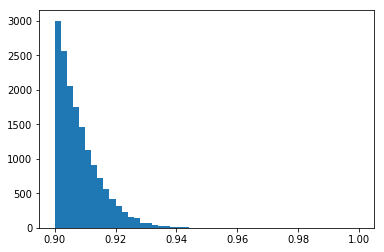

In [18]:
plt.hist([_[2] for _ in data[::100]], bins=50);

The vast majority of these similarity scores are for non matches. Let's zoom into the right side of the distribution.

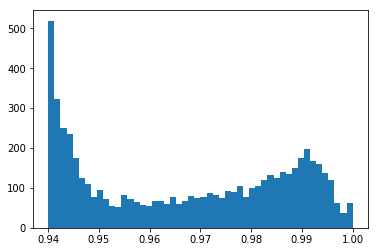

In [19]:
plt.hist([_[2] for _ in data[::1] if _[2] > 0.94], bins=50);

Now it looks like a good threshold should be above `0.95`. Let's have a look at some of the candidate matches around there.

In [20]:
def sample(data, threshold, num_samples, epsilon=0.01):
    samples = []
    for row in data:
        if abs(row[2] - threshold) <= epsilon:
            samples.append(row)
        if len(samples) >= num_samples:
            break
    return samples

def lookup_originals(candidate_pair):
    a = dfA.iloc[candidate_pair[0]]
    b = dfB.iloc[candidate_pair[1]]
    return a, b

In [21]:
def look_at_per_field_accuracy(threshold = 0.999, num_samples = 100):
    results = []
    for i, candidate in enumerate(sample(data, threshold, num_samples, 0.01), start=1):
        record_a, record_b = lookup_originals(candidate)
        results.append(record_a == record_b)

    print("Proportion of exact matches for each field using threshold: {}".format(threshold))
    print(sum(results)/num_samples)

So we should expect a very high proportion of matches across all fields for high thresholds:

In [22]:
look_at_per_field_accuracy(threshold = 0.999, num_samples = 100)

Proportion of exact matches for each field using threshold: 0.999
given_name       0.87
surname          0.87
street_number    0.92
address_1        0.82
address_2        0.64
suburb           0.83
postcode         0.89
state            0.97
date_of_birth    0.96
soc_sec_id       0.83
dtype: float64


But if we look at a threshold which is closer to the boundary between real matches we should see a lot more errors:

In [23]:
look_at_per_field_accuracy(threshold = 0.95, num_samples = 100)

Proportion of exact matches for each field using threshold: 0.95
given_name       0.25
surname          0.31
street_number    0.39
address_1        0.27
address_2        0.25
suburb           0.30
postcode         0.44
state            0.63
date_of_birth    0.40
soc_sec_id       0.49
dtype: float64
